# BA 820 Homework 2

Group Name:Machine not learning

Member Names: Shu Wang, Guang Yang , Jiadai Yu, Zheman Zhong, Sheng Zhou.

Reminder: you should not be sharing code across groups

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [1]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [2]:
import os

data_dir = "data/enron"

processed_docs = []

for filename in os.listdir(data_dir):
    if filename.endswith(".txt"):
        path = os.path.join(data_dir, filename)
        doc = make_word_list(path)
        processed_docs.append(doc)


In [3]:
print(processed_docs[:2]) # checking, printing the first few elements of the list 

['subject leadership development pilot sally what timing ask and you shall receive as per our discussion listed below is an update on the leadership pilot your vendor selection team will receive an update and even more information later in the week on the lunch learn for energy operations the audience and focus will be your group we are ready to start up when appropriate thank you for your time today please call me if you have any questions at x forwarded by julie armstrong corp enron on pm from susan runkel ect pm to cindy skinner hou ect ect brad mcsherry hou ect ect norma villarreal hou ect ect kimberly rizzi hou ect ect fran l mayes hou ect ect gary buck hou ect ect robert jones corp enron enron sheila walton hou ect ect philip conn corp enron enron mary overgaard pdx ect ect kim melodick hou ect ect valeria a hope hou ect ect cc david oxley hou ect ect susan carrera hou ect ect jane allen hou ect ect christine shenkman enron development enron development kathryn mclean hou ect ect

### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=50, stop_words="english", max_df=0.8)
X = vectorizer.fit_transform(processed_docs)

In [5]:
print("Number of unique words in the vocabulary:", len(vectorizer.vocabulary_))

Number of unique words in the vocabulary: 1680


### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [6]:
from sklearn.mixture import GaussianMixture
import numpy as np

gmm = GaussianMixture(n_components=3, random_state = 0)
gmm.fit(X.toarray())
clusters = gmm.predict(X.toarray()) #is predicted cluster assignments returned by GaussianMixture.predict()

n_docs = len(clusters)
for i in range(3):
    n_assigned = np.bincount(clusters)[i]
    print("Number of documents assigned to cluster", i, ":", n_assigned, "(", n_assigned/n_docs*100, "%)")

Number of documents assigned to cluster 0 : 363 ( 7.0199187777992655 %)
Number of documents assigned to cluster 1 : 1785 ( 34.519435312318706 %)
Number of documents assigned to cluster 2 : 3023 ( 58.46064590988204 %)


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [7]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

In [8]:
# Get the feature names from the TfidfVectorizer vocabulary
feature_names = vectorizer.get_feature_names()

# Define "spammy" words
spammy_words = ['click', 'offer', 'www']
spam_indices = [feature_names.index(word) for word in spammy_words]

# Define "hammy" words
hammy_words = ['meeting', 'attached', 'review']
ham_indices = [feature_names.index(word) for word in hammy_words]

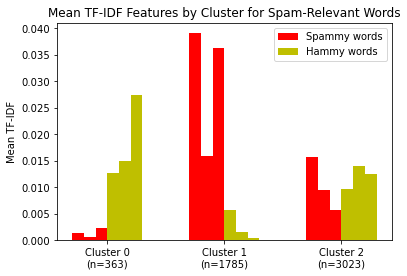

In [9]:
plot_spam_words_by_cluster(X, clusters, 3, spam_indices, ham_indices)

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

*** According to the plot above, cluster 0 seems to correspond to ham emails while cluster 1 correspond to spam emails. And cluster 2 does not correspond to both, since it contains similar numbers of spam and ham words***

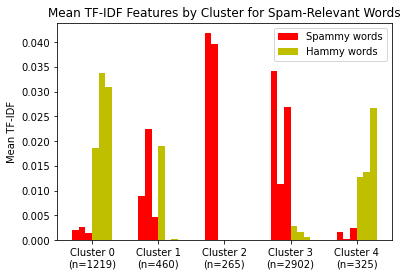

In [10]:
# rerun analysis with n_clusters=5
gmm = GaussianMixture(n_components=5, random_state=0)#n_clusters=5
gmm.fit(X.toarray())

predicted = gmm.predict(X.toarray())

plot_spam_words_by_cluster(X, predicted, 5, spam_indices, ham_indices)

*** As we can see,if we increase the number of clusters,the clusters seems to have better performance on distinguishing spammy and hammy emails.However, this also depends on the random state that we chosen. The results could be unstable if we increase number of clusters. ***

## Question 2: Latent "Purposes" in Mobile Apps [50 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [12]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [13]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [14]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [15]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values
del df # uncomment to free up RAM
del df_perms # uncomment to free up RAM

### Part C: Downweight "stopwords" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [16]:
from sklearn.feature_extraction.text import TfidfTransformer

# apply TF-IDF normalization to X
transformer = TfidfTransformer()
X_tfidf = transformer.fit_transform(X)

# convert sparse matrix to numpy array
X_tfidf = X_tfidf.toarray()

### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [17]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

# create an instance of LatentDirichletAllocation with 10 topics
lda = LatentDirichletAllocation(n_components=10, max_iter=10, n_jobs=-1)

# fit the model to the permission matrix
lda.fit(X_tfidf)

Wall time: 1min 12s


LatentDirichletAllocation(n_jobs=-1)

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [18]:
def ntopwlst(model, features, ntopwords):
    '''create a list of the top topc words'''
    output = []
    for topic_idx, topic in enumerate(model.components_): # compose output message with top words
        output.append('Topic' + '#' + str(topic_idx))
        output += [features[i] for i in topic.argsort()[:-ntopwords - 1:-1]] # [start (0 if omitted): end : slicing increment]
    return output

ntopwords = 10 # change this to show more words for the topic selector (20)
feature_names = permission_columns
topwds = ntopwlst(lda, feature_names, ntopwords)

for i in range (10):
    print('\n'.join(topwds[11*i:11*i+11]))
    print(' ')

Topic#0
Services that cost you money : directly call phone numbers (D)
Your location : fine (GPS) location (D)
Network communication : receive data from Internet (S)
Network communication : full Internet access (D)
Your location : coarse (network-based) location (D)
Network communication : view network state (S)
Phone calls : read phone state and identity (D)
Your location : mock location sources for testing (D)
Storage : modify/delete USB storage contents modify/delete SD card contents (D)
System tools : retrieve running applications (D)
 
Topic#1
Hardware controls : record audio (D)
Hardware controls : change your audio settings (D)
System tools : prevent device from sleeping (D)
System tools : disable keylock (D)
Storage : modify/delete USB storage contents modify/delete SD card contents (D)
Hardware controls : control vibrator (S)
Network communication : create Bluetooth connections (D)
Your personal information : read sensitive log data (D)
Network communication : full Internet ac

*** WRITE YOUR ANSWER HERE IN TEXT ***

Not all topics have corresponding meaningful "purposes".

Topic 3,4,5 all have similar high frequency words of "Network communication" and related stuff.

The following are possible explanantions for materials in topics:

Topic 1:How to set Wi-Fi and connect to internet.

Topic 9:Set and get access to Network(seems to have topic words related to default settings.)

Topic 6:Services provided by network and personal accounts.

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [19]:
topic_proportions = lda.transform(X_tfidf)
for i in range(10):
    idx = np.argsort(topic_proportions[:,i])[::-1]
    standard = app_ratings > 100000
    print("Topic #" + str(i) + ":")
    counter = 3
    for app_idx in idx:
        if counter <= 0:
            break
        if standard[app_idx] == False:
            continue
        app = app_names[app_idx]
        print("\t" + app )
        counter -= 1
    print()

Topic #0:
	eBuddy Messenger
	Talking Tom Cat Free
	Shazam

Topic #1:
	Tango Voice & Video Calls
	Google Maps
	KakaoTalk Mes???sen???ger

Topic #2:
	Ringdroid
	chompSMS
	Zynga Poker

Topic #3:
	Toss It
	GasBuddy
	Dictionary.com

Topic #4:
	Wallpapers HD
	Yoo Ninja! Free
	Angry Birds Seasons

Topic #5:
	Inotia3: Children of Carnia
	Google Sky Map
	Battery Widget

Topic #6:
	Angry Birds
	Angry Birds Rio
	Fruit Slice

Topic #7:
	Restaurant Story™
	Restaurant Story???
	Real BlackJack

Topic #8:
	Brightest Flashlight Free™
	Brightest Flashlight Free???
	Bunny Shooter

Topic #9:
	Blast Monkeys
	Adobe Reader
	Adobe Flash Player 11



### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [15 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.023s...
[t-SNE] Computed neighbors for 2000 samples in 0.380s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.926903
[t-SNE] KL divergence after 1000 iterations: -0.173351


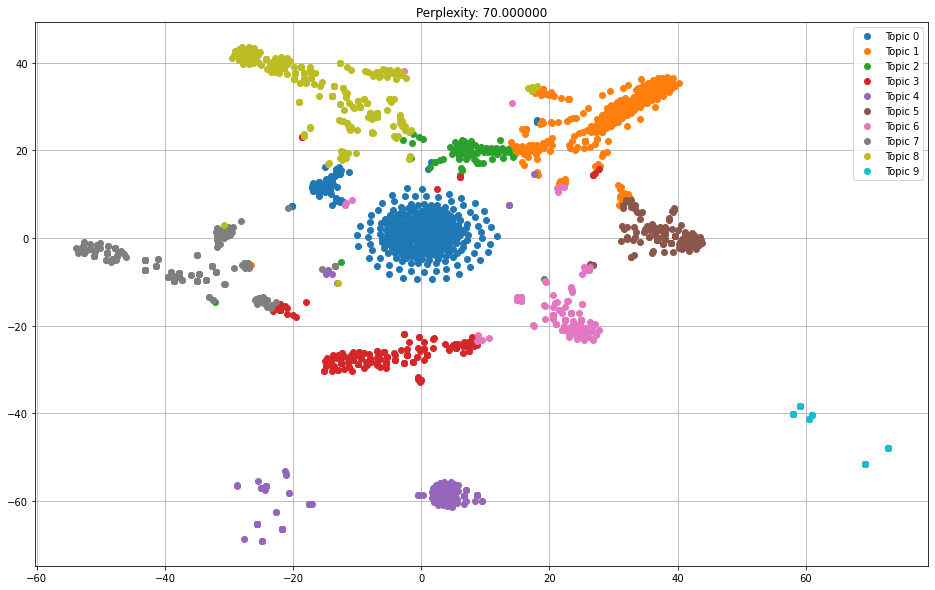

Wall time: 28.2 s


In [20]:
%%time
from sklearn.manifold import TSNE

perplexity = 70
#set parameters of TSNE as required.
tsne_model = TSNE(n_components=2, learning_rate=800, perplexity=perplexity,
                      verbose=1, random_state=0, angle=.99, init='pca')

topic_tsne_lda = tsne_model.fit_transform(topic_proportions[:2000,:])
# choose sample size of 2000 to fit into TSNE
plt.figure(figsize=(16,10))
most_probable_topic = np.argmax(topic_proportions, axis=1)[:2000]
for t in range(10):
    plt.plot(topic_tsne_lda[most_probable_topic==t,0], topic_tsne_lda[most_probable_topic==t,1], 'o',
                 label="Topic " + str(t))
plt.legend(loc='upper right')
plt.title('Perplexity: %f' % perplexity)
plt.grid()
plt.show()

Based on our above plot,perplexity = 70 has a separable cluster of different topics and the graph is visually pleasing.We may also try fine-tuning parameters like angle or increase sample size to get more accurate results.